# Лабораторная работа № 2

## Выполнил: Некрасов Константин М8О-310Б

Необходимо решить задачу бинарной классификации на датасете относительно целевой переменной `LoanApproved`

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

Структура датасета имеет следующий вид:

In [5]:
train = pd.read_csv('train.csv')
train.columns.tolist()

['ApplicationDate',
 'Age',
 'AnnualIncome',
 'CreditScore',
 'LoanAmount',
 'LoanDuration',
 'MaritalStatus',
 'NumberOfDependents',
 'HomeOwnershipStatus',
 'MonthlyDebtPayments',
 'CreditCardUtilizationRate',
 'NumberOfOpenCreditLines',
 'NumberOfCreditInquiries',
 'DebtToIncomeRatio',
 'BankruptcyHistory',
 'LoanPurpose',
 'PreviousLoanDefaults',
 'PaymentHistory',
 'LengthOfCreditHistory',
 'SavingsAccountBalance',
 'CheckingAccountBalance',
 'TotalAssets',
 'TotalLiabilities',
 'MonthlyIncome',
 'UtilityBillsPaymentHistory',
 'JobTenure',
 'EmploymentStatus',
 'EducationLevel',
 'Experience',
 'NetWorth',
 'BaseInterestRate',
 'InterestRate',
 'MonthlyLoanPayment',
 'TotalDebtToIncomeRatio',
 'LoanApproved',
 'RiskScore']

Для начала предобработка. Из решения контеста понятно, что в датасете `train.csv` есть аномалии по `RiskScore` и пропуски, их следует обработать

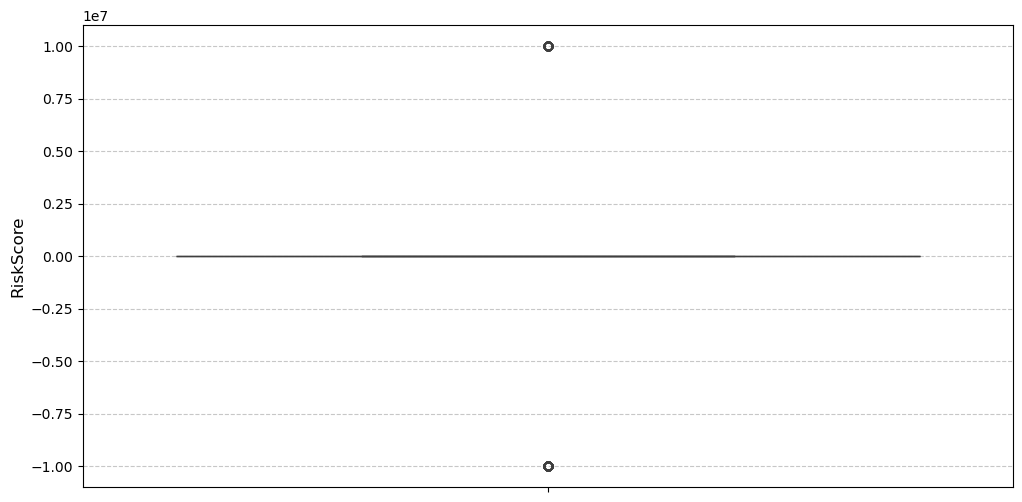

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(y=train['RiskScore'])
plt.ylabel('RiskScore', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

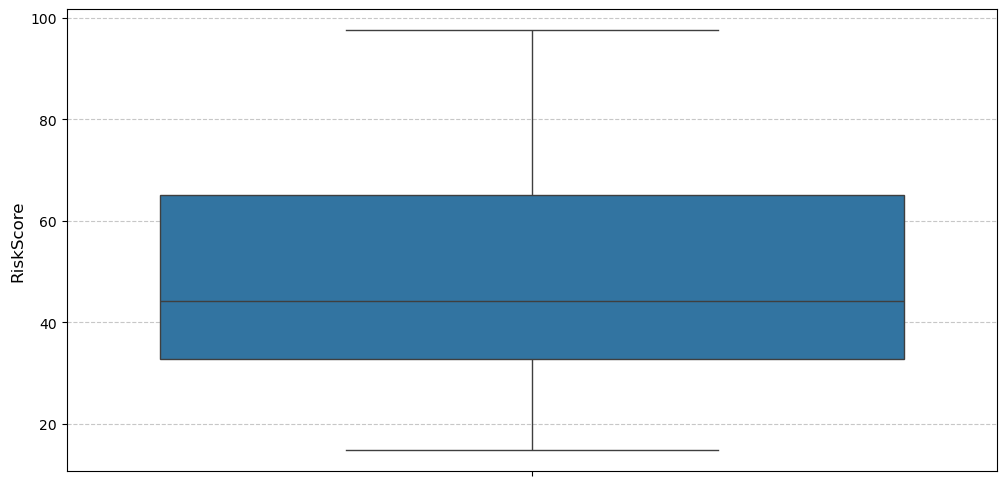

In [11]:
q1 = train['RiskScore'].quantile(0.25)
q3 = train['RiskScore'].quantile(0.75)

iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = train[(train['RiskScore'] < lower_bound) | (train['RiskScore'] > upper_bound)]

if not outliers.empty:
    train = train.drop(outliers.index)

plt.figure(figsize=(12, 6))
sns.boxplot(y=train['RiskScore'])
plt.ylabel('RiskScore', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

В датасете есть пропуски, заполним их как на контесте

In [13]:
train.isnull().sum()

ApplicationDate                 0
Age                             0
AnnualIncome                    0
CreditScore                   485
LoanAmount                    485
LoanDuration                    0
MaritalStatus                   0
NumberOfDependents              0
HomeOwnershipStatus             0
MonthlyDebtPayments           485
CreditCardUtilizationRate       0
NumberOfOpenCreditLines         0
NumberOfCreditInquiries         0
DebtToIncomeRatio               0
BankruptcyHistory             485
LoanPurpose                   485
PreviousLoanDefaults            0
PaymentHistory                  0
LengthOfCreditHistory           0
SavingsAccountBalance           0
CheckingAccountBalance        485
TotalAssets                   485
TotalLiabilities                0
MonthlyIncome                   0
UtilityBillsPaymentHistory      0
JobTenure                       0
EmploymentStatus                0
EducationLevel                  0
Experience                      0
NetWorth      

In [15]:
categorical = train.select_dtypes(include=['object']).columns
numerical = train.select_dtypes(include=['int64', 'float64']).columns

# заполнение категориальных пропусков модой
for col in categorical:
    mode = train[col].mode()[0]
    train.fillna({col: mode}, inplace=True)

# заполнение скалярных признаков
imputer = KNNImputer(n_neighbors=5)

train[numerical] = imputer.fit_transform(train[numerical])

# кодирование категориальных признаков
encoder = OneHotEncoder(sparse_output=False)

categorical_encoded = encoder.fit_transform(train[categorical[1:]])
encoded_cat = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical[1:]))

# нормализация скалярных признаков
scaler = StandardScaler()

numerical_train = train[numerical]
numerical_train = scaler.fit_transform(numerical_train)

normalized_num = pd.DataFrame(numerical_train, columns=numerical)

# конкатенация категориальных и скалярных признаков
normalized_num = normalized_num.reset_index(drop=True)
encoded_cat = encoded_cat.reset_index(drop=True)

logistic_regression_data = pd.concat([normalized_num, encoded_cat], axis=1)
logistic_regression_data

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,LoanPurpose_Home,LoanPurpose_Other,EmploymentStatus_Employed,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed,EducationLevel_Associate,EducationLevel_Bachelor,EducationLevel_Doctorate,EducationLevel_High School,EducationLevel_Master
0,-1.108451,-0.558650,-0.741546,-0.456579,0.268131,-0.400573,1.113292,-0.831696,-0.591929,0.022255,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.304533,0.350659,0.986774,-0.499734,-0.710632,-0.400573,-0.679621,-0.682975,-0.016743,-0.989281,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.959821,1.454535,0.986774,0.316767,-0.710632,-1.105987,-0.000180,1.003963,-0.016743,-0.989281,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.280807,-0.836197,0.969549,-0.387239,-0.221251,-1.105987,-0.797256,-0.602935,2.284003,-0.989281,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.304533,1.454535,0.986774,0.024230,-0.221251,0.304842,0.032271,-0.069843,-0.016743,0.022255,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10267,-0.074315,1.454535,0.986774,-0.806534,0.757512,2.421084,-0.547789,-0.435536,-0.591929,0.022255,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10268,1.476889,1.454535,0.986774,-0.549252,-0.221251,0.304842,0.149906,1.211837,-1.167115,2.045329,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10269,-1.022273,-1.006139,-2.171286,0.789457,1.736274,-0.400573,0.304047,0.238311,-0.591929,-0.989281,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10270,-1.453163,-1.006139,-2.159802,0.034726,0.757512,1.010256,-0.269928,1.333035,-0.591929,-0.989281,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


Посмотрим, сбалансированны ли классы

In [17]:
len(train[train['LoanApproved'] == 1]), len(train[train['LoanApproved'] == 0])

(5257, 5015)

Классы сбалансированны, поэтому можно использовать для оценивания ROC-кривую. Целевая переменная для всех моделей одинаковая

In [19]:
y = train['LoanApproved']

1. Написать класс, реализующий свой линейный классификатор и логистическую регрессию с методами fit и predict.

## Кастомный линейный классификатор

Адаптация переменных контеста для новой задачи

In [86]:
X_train, X_test, y_train, y_test = train_test_split(logistic_regression_data, y, test_size=0.2)

Определение класса логистической регрессии:

In [88]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_class = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_class)

In [239]:
customCLF = CustomLogisticRegression(learning_rate=0.01, n_iter=1000)

customCLF.fit(X_train, y_train)

customCLF_pred = customCLF.predict(X_test)

customCLF_pred_test = (customCLF_pred, y_test) # сохранение для дальнейшего построения графика

2. Решить задачу с помощью готовых реализаций:
- Логистическая регрессия: sklearn
- SVM: sklearn
- Решающее дерево: sklearn
- Случайный лес: sklearn
- Градиентный бустинг: sklearn, LightGBM, XGBoost, catboost

## Логистическая регрессия

In [92]:
from sklearn.linear_model import LogisticRegression

In [94]:
lr_X_train, lr_X_test, y_train, y_test = train_test_split(logistic_regression_data, y, test_size=0.2)

In [96]:
skl_lr = LogisticRegression()
skl_lr.fit(lr_X_train, y_train)
skl_lr_pred = skl_lr.predict(lr_X_test)

skl_lr_pred_test = (skl_lr_pred, y_test) 

## SVM

In [98]:
from sklearn.svm import SVC

In [100]:
svm_X_train, svm_X_test, y_train, y_test = train_test_split(logistic_regression_data, y, test_size=0.2)

In [102]:
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(svm_X_train, y_train)
svm_pred = svm_model.predict(svm_X_test)

svm_pred_test = (svm_pred, y_test) 

## Решающее дерево

In [104]:
from sklearn.tree import DecisionTreeClassifier

In [106]:
dt_X_train, dt_X_test, y_train, y_test = train_test_split(logistic_regression_data, y, test_size=0.2)

In [108]:
dt_model = DecisionTreeClassifier()
dt_model.fit(dt_X_train, y_train)
dt_pred = dt_model.predict(dt_X_test)

dt_pred_test = (dt_pred, y_test) 

## Случайный лес

In [110]:
from sklearn.ensemble import RandomForestClassifier

In [112]:
rf_X_train, rf_X_test, y_train, y_test = train_test_split(logistic_regression_data, y, test_size=0.2)

In [114]:
rf_model = RandomForestClassifier()
rf_model.fit(rf_X_train, y_train)
rf_pred = rf_model.predict(rf_X_test)

rf_pred_test = (rf_pred, y_test) 

## Градиентный бустинг

### Sklearn

In [116]:
from sklearn.ensemble import GradientBoostingClassifier

In [118]:
skl_gb_X_train, skl_gb_X_test, y_train, y_test = train_test_split(logistic_regression_data, y, test_size=0.2)

In [120]:
gb_model = GradientBoostingClassifier()
gb_model.fit(skl_gb_X_train, y_train)
skl_gb_pred = gb_model.predict(skl_gb_X_test)

skl_gb_pred_test = (skl_gb_pred, y_test) 

### LightGBM

In [122]:
import lightgbm as lgb

In [128]:
lgb_X_train, lgb_X_test, y_train, y_test = train_test_split(logistic_regression_data, y, test_size=0.2)

In [130]:
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(lgb_X_train, y_train)
lgb_pred = lgb_model.predict(lgb_X_test)

lgb_pred_test = (lgb_pred, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4213, number of negative: 4004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4871
[LightGBM] [Info] Number of data points in the train set: 8217, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512718 -> initscore=0.050881
[LightGBM] [Info] Start training from score 0.050881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

### XGBoost

In [133]:
from xgboost import XGBClassifier

In [135]:
xgb_X_train, xgb_X_test, y_train, y_test = train_test_split(logistic_regression_data, y, test_size=0.2)

In [137]:
xgb_model = XGBClassifier()
xgb_model.fit(xgb_X_train, y_train)
xgb_pred = xgb_model.predict(xgb_X_test)

xgb_pred_test = (xgb_pred, y_test)

### CatBoost

In [140]:
from catboost import CatBoostClassifier

In [142]:
cat_X_train, cat_X_test, y_train, y_test = train_test_split(logistic_regression_data, y, test_size=0.2)

In [144]:
cat_model = XGBClassifier()
cat_model.fit(cat_X_train, y_train)
cat_pred = xgb_model.predict(cat_X_test)

cat_pred_test = (cat_pred, y_test)

3. Посчитать метрики precision, recall, F1-меру, accuracy для всех решений, визуализировать confusion matrix (с помощью matplotlib/seaborn/любая другая библиотека для визуализации) также для всех решений.

## Сравнение метрик

In [175]:
from sklearn.metrics import confusion_matrix

Для начала объединим результаты и имена моделей для удобства

In [179]:
pred_tests = [
    customCLF_pred_test, 
    skl_lr_pred_test, 
    svm_pred_test, 
    dt_pred_test, 
    rf_pred_test, 
    skl_gb_pred_test, 
    lgb_pred_test, 
    xgb_pred_test, 
    cat_pred_test
]

model_names = [
    'CustomLogisticRegression',
    'Sklearn logistic regression',
    'SVM',
    'Decision Tree',
    'Random Forest',
    'Gradient Boost',
    'LightGBM',
    'XGBoost',
    'CatBoost'
]

Метрики для моделей можно рассчитать с помощью матрицы ошибок. Сразу же их визуализируем:

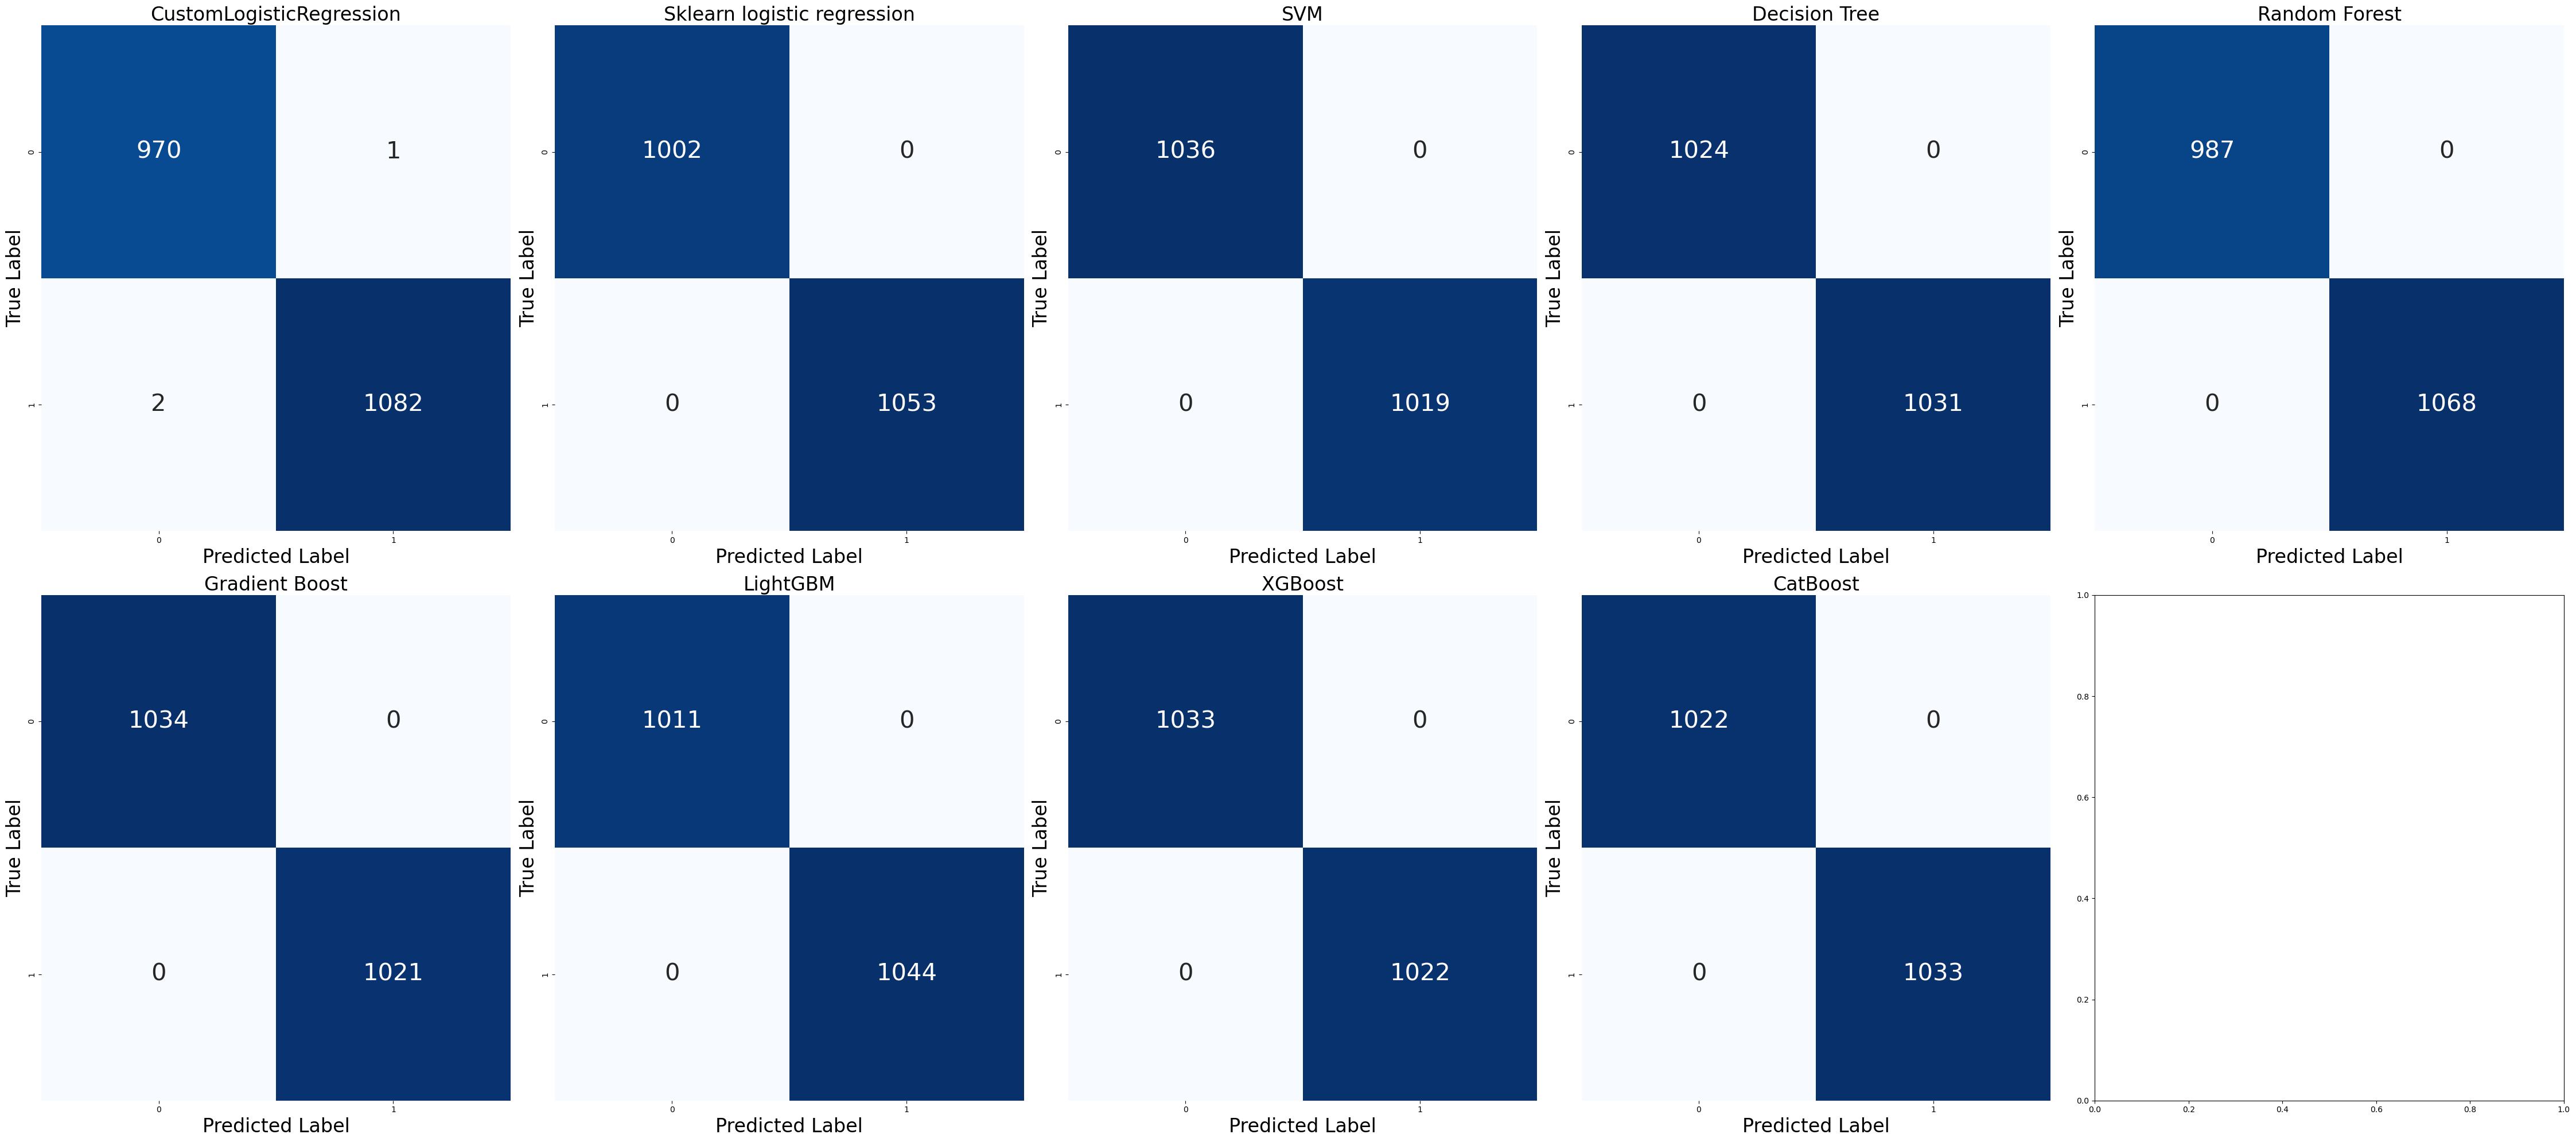

In [218]:
fig, axes = plt.subplots(2, 5, figsize=(45, 20)) 

for i, (model_name, (y_pred, y_test)) in enumerate(zip(model_names, pred_tests)):
    row, col = divmod(i, 5)
    cm = confusion_matrix(y_test, np.where(y_pred > 0.5, 1, 0))
    ax = axes[row, col]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={"size": 30})
    ax.set_title(f'{model_name}', fontsize=24)
    ax.set_xlabel('Predicted Label', fontsize=24)
    ax.set_ylabel('True Label', fontsize=24)
plt.tight_layout()
plt.show()

Теперь отобразим метрики с помощью ROC-кривых:

In [221]:
from sklearn.metrics import auc, roc_curve

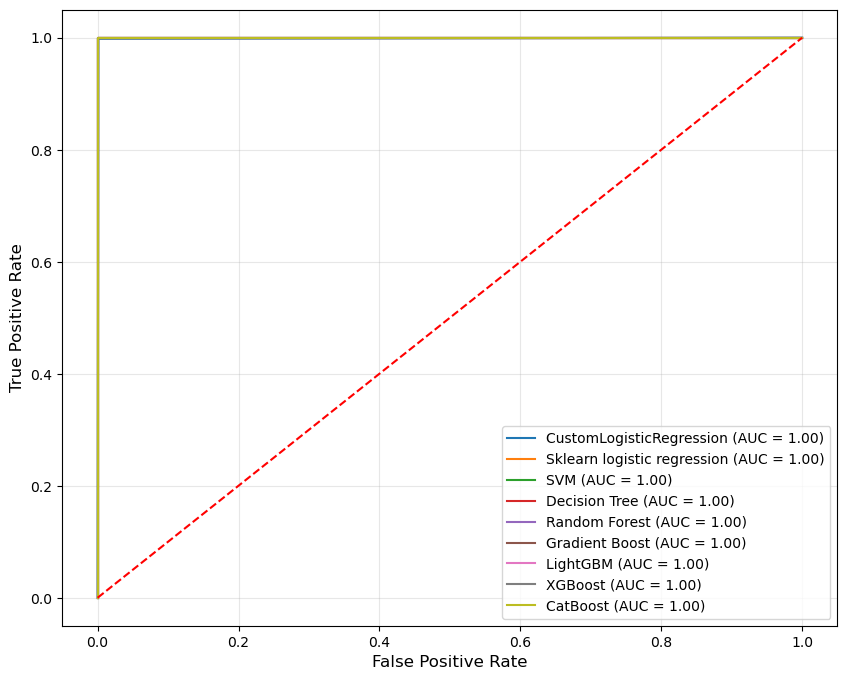

In [246]:
plt.figure(figsize=(10, 8))
    
for model_name, (y_pred, y_test) in zip(model_names, pred_tests):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)  
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

4. Сделать выводы.

## Выводы

В результате работы можно сделать вывод о том, что модели однозначно определяют классы объектов выборки, а сами классы линейно разделимы. При увеличении масштаба графика можно рассмотреть незначительные различия между кривыми, но эти отличия очень малы.

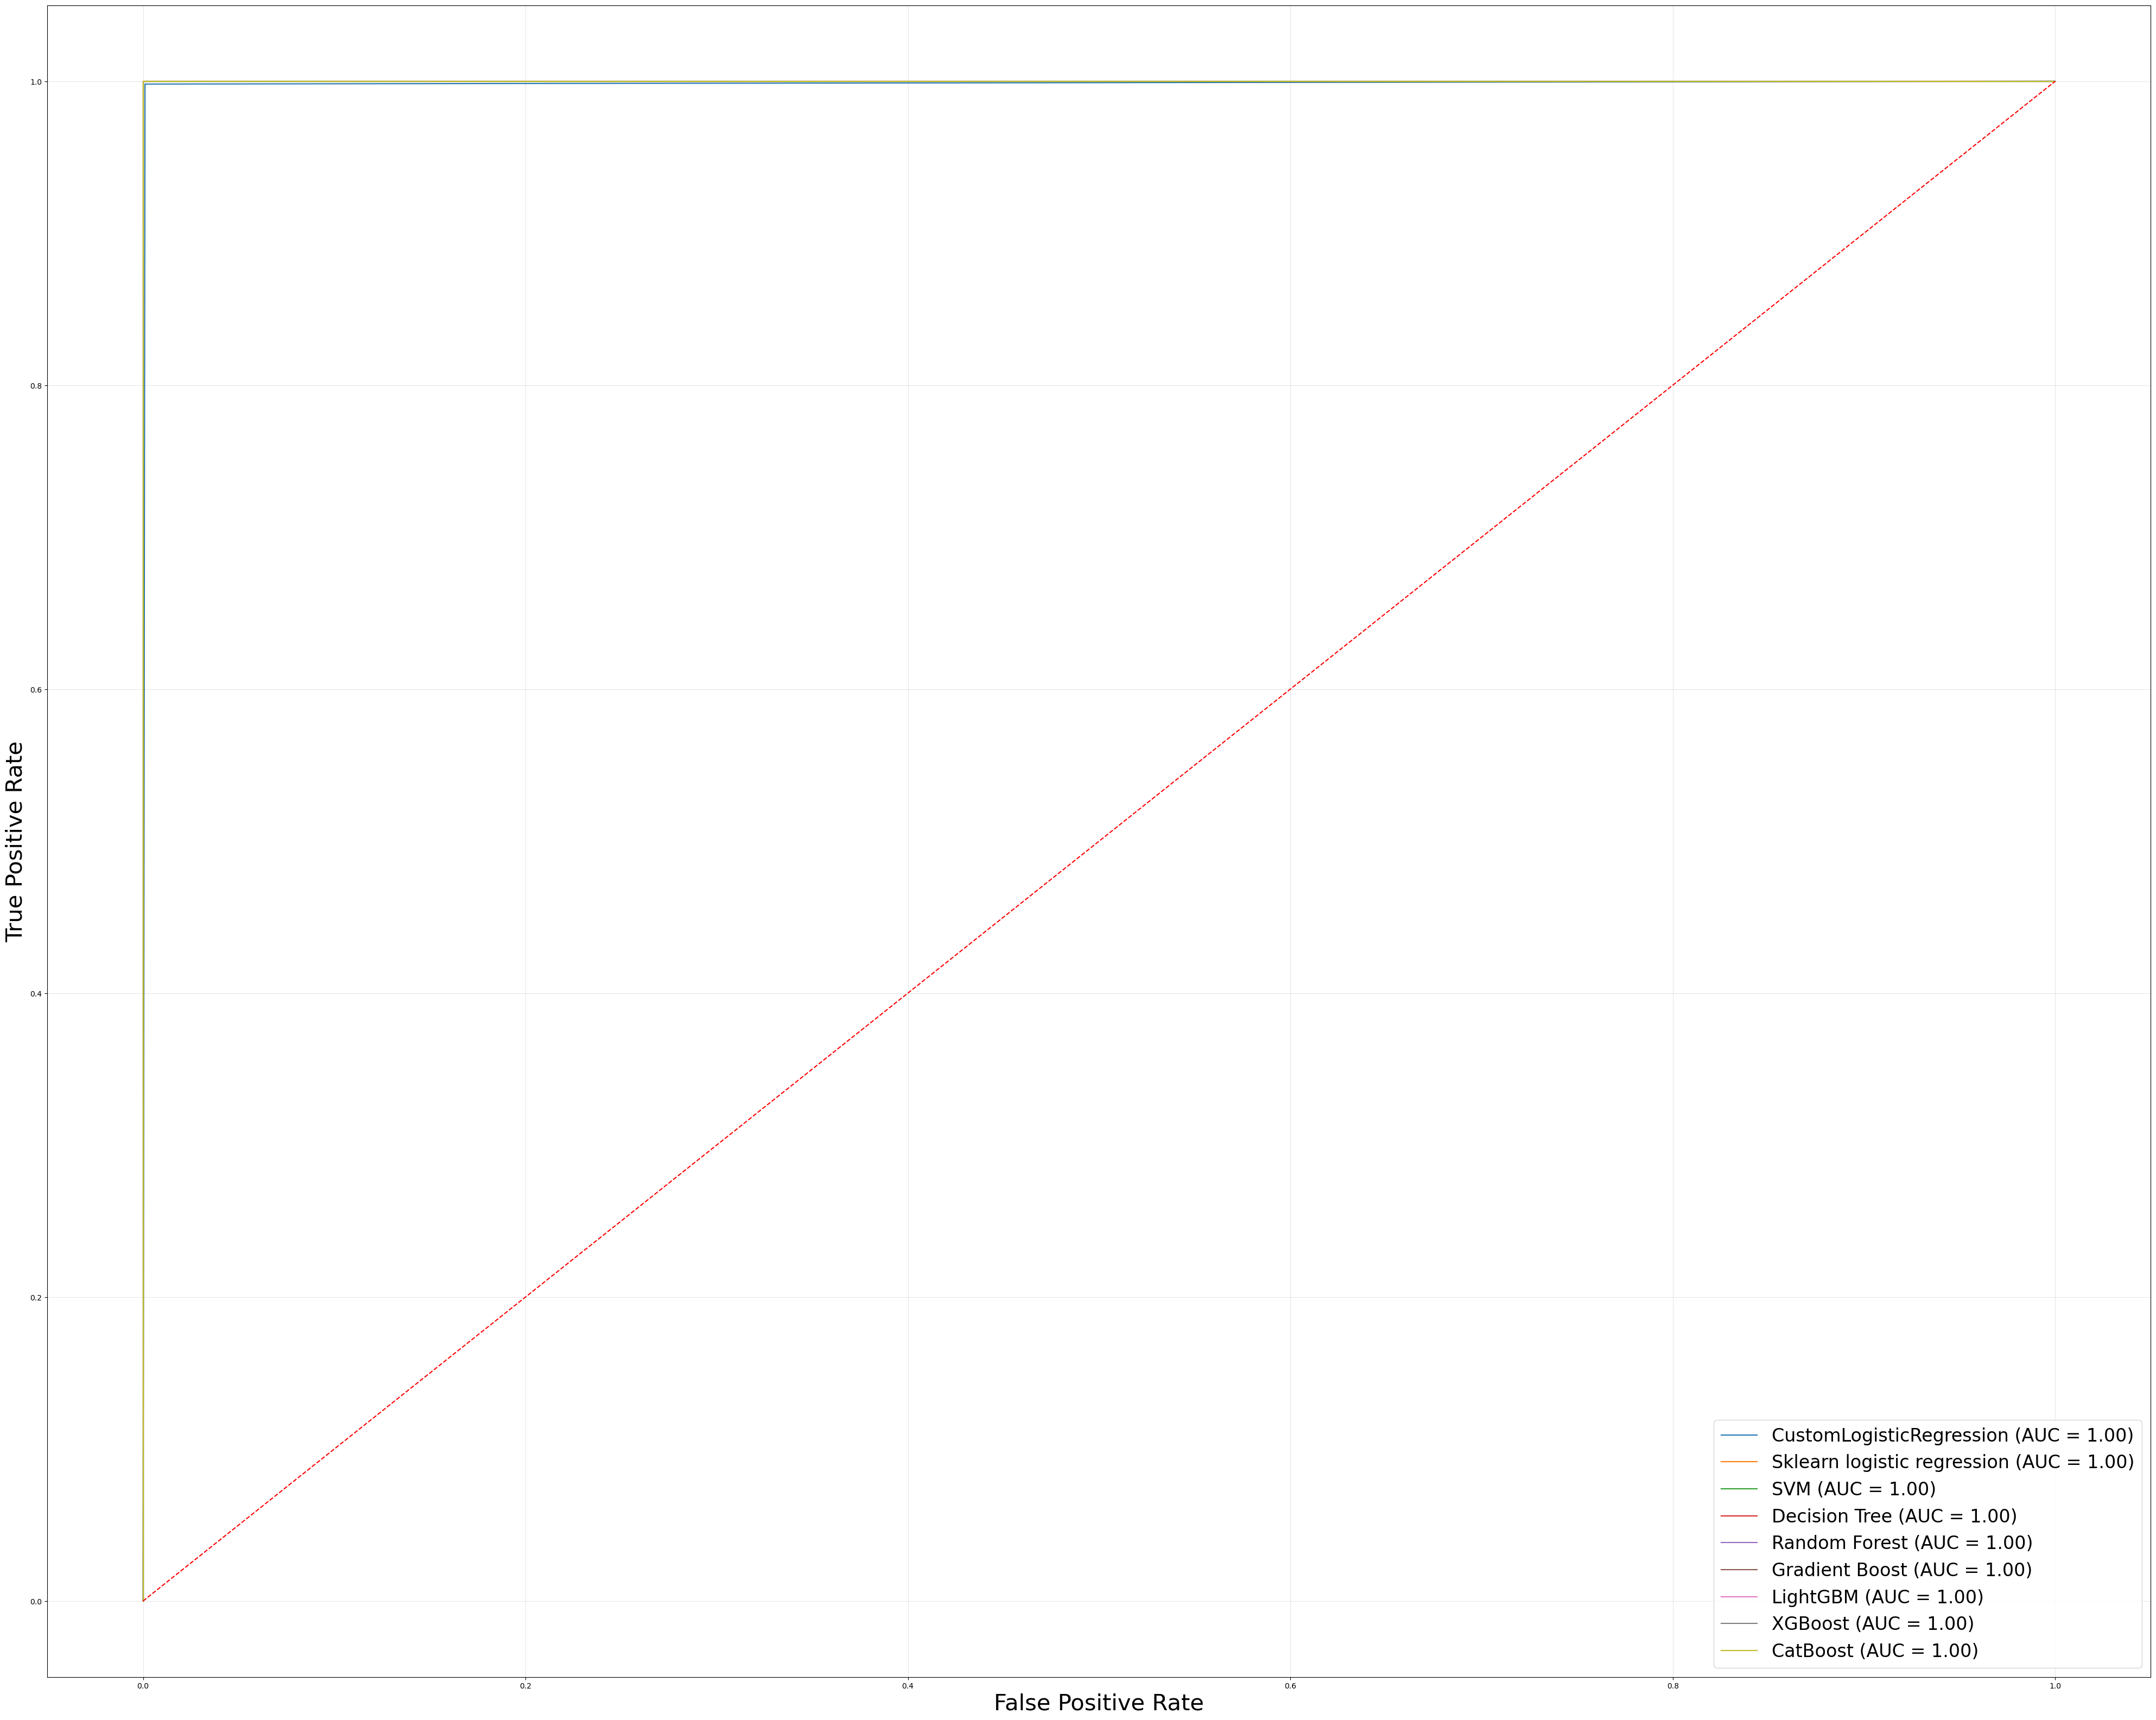

In [259]:
plt.figure(figsize=(50, 40)) # увеличение размера фигуры без увеличения толщины линий
    
for model_name, (y_pred, y_test) in zip(model_names, pred_tests):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)  
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate", fontsize=30)
plt.ylabel("True Positive Rate", fontsize=30)
plt.legend(loc='lower right', fontsize=24)
plt.grid(alpha=0.3)
plt.show()